# Image Captioning with Attention



## Image Captioning with Attention

The use of Attention networks is widespread in deep learning, and with good reason. This is a way for a model to choose only those parts of the encoding that it thinks is relevant to the task at hand. The same mechanism you see employed here can be used in any model where the Encoder's output has multiple points in space or time. In image captioning, you consider some pixels more important than others. In sequence to sequence tasks like machine translation, you consider some words more important than others.

In here, we will design and train a Image captioning network with Attention mechanism from scratch to process the input image, then output a sequence that describe the image. 

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

I use `python 3.8.11`, `torch==1.8.2` and `torchvision==0.9.2`.

In [ ]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.8.16 (default, Dec  7 2022, 01:12:13) 
torch 1.13.0+cu116
torchvision 0.14.0+cu116


## Error handling

**RuntimeError: CUDA out of memory...**
> 發生原因可能為讀取的 batch 過大或是記憶體未釋放乾淨。若縮小 batch size 後仍出現錯誤請按照以下步驟重新載入 colab。
> The reason of this error is over-sized batch_size or unreleased memory. If changing the batch_size smaller still cause this error. Please reload colab follow below instructions.

1. Click 「Runtime」
2. Click 「Factor reset runtime」
3. Click 「Reconnect」
4. Reload all chunk



# Prepare Data

For reference, we use [Flickr8k](https://www.kaggle.com/dataset/e1cd22253a9b23b073794872bf565648ddbe4f17e7fa9e74766ad3707141adeb) dataset.
This dataset is collected by Alexander Mamaev.

**Abstrct**  
A new benchmark collection for sentence-based image description and search, consisting of 8,091 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations

Photos are not reduced to a single size, they have different proportions!





## How to Get Data

Please open the file `flickr8k.zip`, creat shortcut to your Google Drive.

1. open [LINK of Google Drive](https://drive.google.com/file/d/1awvS-E5IPMJgu6kiRjZbiwyrmx6Cl6VO/view?usp=sharing)
2. Click "Add shortcut to Drive" in the top-right corner.
3. Select the location where you want to place the shortcut.
4. Click Add shortcut.

After above procedures, we have a shortcut of zip file of dataset.  
We can access this in colab after granting the permission of Google Drive.

1. Executing the below code which will provide you with an authentication link
2. Open the link
3. Choose the Google account whose Drive you want to mount
4. Allow Google Drive Stream access to your Google Account
5. Copy the code displayed, paste it in the text box as shown below, and press Enter
![](https://i1.wp.com/neptune.ai/wp-content/uploads/colab-code-copy.png?resize=512%2C102&ssl=1)

Finish!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unzip Data

Unzip `flickr8k.zip`, there are 2 folders and 1 txt.

- `images/`: contains images for training.
- `test_examples/`: contains images for testing.
- `captions.txt`: the file_names and their captions.

There are **8091 images in images.**  
There are **5 images in test_examples.**   

In [ ]:
!unzip -qq ./drive/My\ Drive/flickr8k.zip

replace flickr8k/captions.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
import numpy as np
import torch.nn as nn
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step1 Data Processing & DataLoader

In [ ]:
# Download with: python -m spacy download en 
# the tokenize
spacy_eng = spacy.load("en_core_web_sm")

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"} #some index to string
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3} #some string to index
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)] #lowercase all the words
        # "I like Deep Learning" >>> ["i", "like", "deep", "learning"]
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4 # 0-3 have already been used

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [ ]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim = 0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first = False, padding_value = self.pad_idx)

        return imgs, targets

In [ ]:
def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size = 128,
    num_workers = 8,
    shuffle = True,
    pin_memory = True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform = transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset = dataset,
        batch_size = batch_size,
        num_workers = num_workers,
        shuffle = shuffle,
        pin_memory = pin_memory,
        collate_fn = MyCollate(pad_idx = pad_idx),
    )

    return loader, dataset

## Design Augmentation

### Data augmentation 

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

PyTorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/vision/stable/transforms.html)



In [ ]:
transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.RandomCrop((224, 224)),

                                # transforms.ColorJitter(brightness = 0.5),
                                # transforms.RandomHorizontalFlip(p = 0.5),
                                # transforms.RandomRotation(degrees=(-90, 90)),

                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2023, 0.1994, 0.2010])])

In [ ]:
train_loader, dataset = get_loader(
  root_folder="flickr8k/images/",
  annotation_file="flickr8k/captions.txt",
  transform=transform,
  num_workers=4,
)

dataL = iter(train_loader)
imgs, captions = next(dataL)
print("Shape of the imgs : ", imgs.shape)
print("Shape of the captions : ", captions.shape)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Shape of the imgs :  torch.Size([128, 3, 224, 224])
Shape of the captions :  torch.Size([22, 128])


# Build Model Structure


<a id='step3'></a>
## Step 2: Implement the CNN Encoder


We use pre-trained models like ResNet-50 architecture (with the final fully-connected layer removed) to extract features from a batch of pre-processed images. 

In the code cell below, `features` should be a PyTorch tensor with size `[batch_size, num_pixels, encoder_dim]`.

Ex.if your pretrained model is resnet50, your output `features` should be the size of `[batch_size, 49, 2048]`.

In [ ]:
class EncoderAttentionCNN(nn.Module):
    def __init__(self):
        super(EncoderAttentionCNN, self).__init__()
        # self.enc_image_size = encoded_image_size
        
        resnet = torchvision.models.resnet50(pretrained=True)

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        # self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        # self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.5)

        self.fine_tune()

    def forward(self, images):
        
        features = self.resnet(images)

        # features = self.adaptive_pool(features)
        features = features.permute(0, 2, 3, 1)

        features = features.view(features.size(0), -1, features.size(-1))

        return features #(batch_size, num_pixels, encoder_dim) ,if pretrained = resnet50: (batch_size ,49, 2048)

    def fine_tune(self, fine_tune=True):
        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

<a id='step4'></a>
## Step 3:  Implement Attention Module

In this part, we design our Attention Module.

In the code cell below, the output `alpha` should be a PyTorch tensor with size `[batch_size, num_pixels]`, and the output `attention_weights` should be a PyTorch tensor with size `[batch_size, encoder_dim]`.  

In [ ]:
# Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim

        #  The layers should be some Linear layers                
        self.encoder_att = nn.Linear(encoder_dim, attention_dim) # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim) # linear layer to transform decoder's output
        
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights
        
    def forward(self, features, hidden_state):
        # features (batch_size, num_pixels, encoder_dim)
        # hidden_state (batch_size, decoder_dim)

        atten_1 = self.encoder_att(features)  # (batch_size, num_pixels, attention_dim)
        atten_2 = self.decoder_att(hidden_state)  # (batch_size, attention_dim)
        
        combined_atten = self.full_att(torch.tanh(atten_1 + atten_2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels, attention_dim)
        
        alpha = self.softmax(combined_atten)  # (batch_size, num_pixels)
        attention_weights = (features * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim or called features_dim)
        
        return attention_weights, alpha  # alpha:(batch_size, num_pixels)  attention_weights:#(batch_size, features_dim)

<a id='step4'></a>
## Step 4:  Implement the Attention RNN Decoder

In this part, we design our Attention RNN Decoder.

For Attention RNN Decoder, the iteration is performed manually in a for loop with a PyTorch `LSTMCell` instead of iterating automatically without a loop with a PyTorch `LSTM`. This is because we need to execute the Attention mechanism between each decode step. An `LSTMCell` is a single timestep operation, whereas an `LSTM` would iterate over multiple timesteps continously and provide all outputs at once.


In [ ]:
# Attention Decoder
class DecoderAttentionRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.dropout = drop_prob
        
        # The LSTM layer should be nn.LSTMCell instead of nn.LSTM   
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network
        self.embedding = nn.Embedding(vocab_size, embed_size)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        
        self.f_beta = nn.Linear(decoder_dim, encoder_dim) # linear layer to create a sigmoid-activated gate
        self.fc = nn.Linear(decoder_dim, vocab_size)

        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.
        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).
        :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        # encoder_out (batch_size, num_pixels, encoder_dim)

        mean_encoder_out = encoder_out.mean(dim=1)
        # mean_encoder_out (batch_size, encoder_dim)
      
        # Use the init_h & init_c layers to get the hidden_state and the cell
        h = self.init_h(mean_encoder_out)
        # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        # (batch_size, decoder_dim)

        return h, c

    def forward(self, features, captions):
      
        # We first embed the captions                      
        # Then draw the hidden_state and the cell from the image features
        
        batch_size = features.size(0)
        encoder_dim = features.size(-1)

        features = features.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)

        # vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)
        # both are the size of (batch_size, decoder_dim) 
         
        # get the seq length to iterate
        seq_length = len(captions[0])-1 # Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(device)
        
        for s in range(seq_length):
            
            # Get the attention output from the attention module      
            attention_weight, alpha = self.attention(features, h)
            
            lstm_input = torch.cat((embeds[:, s], attention_weight), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fc(self.dropout(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas


    # Testing Phase
    def generate_caption(self, features, max_len=20, vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        # encoder_dim = features.size(-1)

        # features = features.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)

        # Initialize the LSTM state with the same method in training phase            
        # draw the hidden_state and the cell from the image features                  
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features) 
        # both are the size of (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)
        
        captions = []
        
        for i in range(max_len):

            # Get the attention output from the attention module         
            attention_weight, alpha = self.attention(features, h)
            
            # store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], attention_weight), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fc(self.dropout(h))
            output = output.view(batch_size, -1)      
            
            # select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            # save the generated word
            captions.append(predicted_word_idx.item())
            
            # end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            # send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        # covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions], alphas

<a id='step4'></a>
## Step 5: Combine the Encoder with Decoder

In this part, we combline the encoder and the decoder designed above. To do that, you simply have to take the outputs of your encoder and the captions and send them into the decoder.





In [ ]:
class CNNtoAttentionRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderAttentionCNN()
        self.decoder = DecoderAttentionRNN(
            embed_size = embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim = attention_dim,
            encoder_dim = encoder_dim,
            decoder_dim = decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

#Traning Process

<a id='step5'></a>
## Step 6: Training Settings

In [ ]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4
grad_clip = 5

In [ ]:
#init model
model = CNNtoAttentionRNN(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [3, 6], gamma = 0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

<a id='step6'></a>
## Step 7: Train Your Model

In [ ]:
num_epochs = 25
print_every = 100

for epoch in range(1,num_epochs+1):   
    
    for idx, (image, captions) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        image, captions = image.to(device), captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()
        
        captions = captions.permute(1, 0)
        
        # Feed forward
        outputs, attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update the parameters in the optimizer.
        optimizer.step()
        
        # scheduler.step()

#         if (idx+1)%print_every == 0:
#             print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
    stat_vals = 'Epochs [%d/%d] ------- Loss [%.4f] ' %( epoch, num_epochs, loss.item() )
    print(stat_vals)

    save_model(model,epoch)

Epochs [1/25] ------- Loss [3.1462] 


Epochs [2/25] ------- Loss [2.8850] 


Epochs [3/25] ------- Loss [2.6423] 


Epochs [4/25] ------- Loss [3.2916] 


Epochs [5/25] ------- Loss [1.8950] 


Epochs [6/25] ------- Loss [3.0989] 


Epochs [7/25] ------- Loss [2.5003] 


Epochs [8/25] ------- Loss [2.0675] 


Epochs [9/25] ------- Loss [2.0583] 


Epochs [10/25] ------- Loss [1.7155] 


Epochs [11/25] ------- Loss [2.5464] 


Epochs [12/25] ------- Loss [2.3487] 


Epochs [13/25] ------- Loss [1.6722] 


Epochs [14/25] ------- Loss [2.0626] 


Epochs [15/25] ------- Loss [2.3368] 


Epochs [16/25] ------- Loss [1.8536] 


Epochs [17/25] ------- Loss [1.4465] 


Epochs [18/25] ------- Loss [1.8003] 


Epochs [19/25] ------- Loss [1.8237] 


Epochs [20/25] ------- Loss [1.6800] 


Epochs [21/25] ------- Loss [1.9306] 


Epochs [22/25] ------- Loss [1.9732] 


Epochs [23/25] ------- Loss [1.9830] 


Epochs [24/25] ------- Loss [1.7737] 


Epochs [25/25] ------- Loss [1.5909] 


#Check The Results

<a id='step7'></a>
## Step 8: Simple Test

This part is for the testing. After training, run the codes below to see some example captioning output.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
# generate caption
def get_caps_from(features_tensors):
    # generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0], title = caption)
    
    return caps, alphas

# Show attention
def plot_attention(img, result, attention_plot):
    # untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    
    for l in range(len_result):

        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.8, extent=img.get_extent())      

    plt.tight_layout()
    plt.show()
    
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    # unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0)) 
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

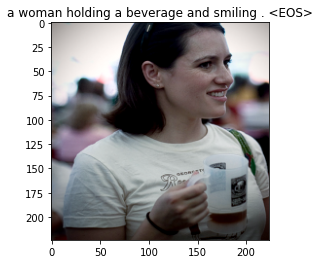

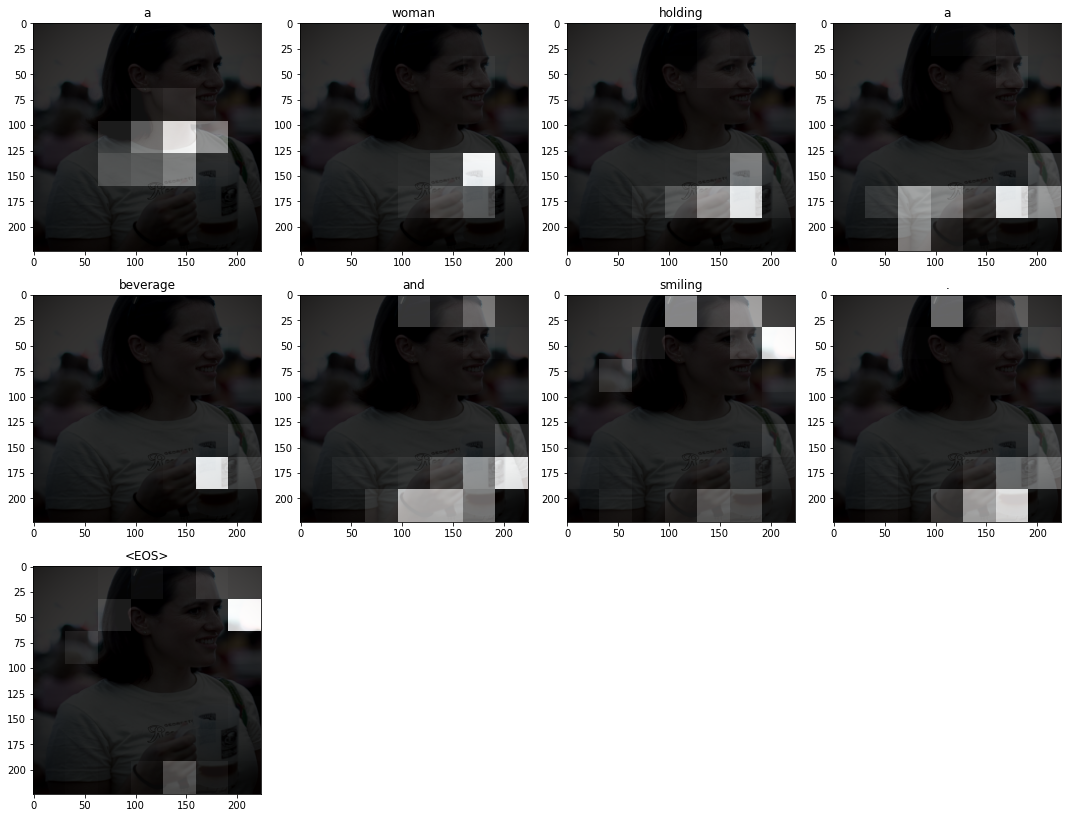

In [ ]:
# show any 1
dataiter = iter(train_loader)
images, _ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps, alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)